In [3]:
import os
from pprint import pprint
import numpy as np
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
#Fucntion to extract image and label pathces
def extract_3D_patch(images):
    # convert image data to tensor
    imgs = np.expand_dims(images, [0, -1])
    t_imgs = tf.convert_to_tensor(imgs, dtype='float32')
    # Extract voulm patches: 30x48x48
    t_patches = tf.extract_volume_patches(
        t_imgs,
        ksizes=[1, 30, 48, 48, 1],
        strides=[1, 30, 48, 48, 1],
        padding='SAME'
    )
    img_patches = tf.reshape(t_patches, (-1 ,30, 48, 48, 1))
   
    return img_patches


In [6]:
#function to extract pathces with annoations
def extract_patch_labels(t_lbl_patches, method='max'):
    if method == 'max':
        t_patch_labels = tf.reduce_max(t_lbl_patches, axis=[1,2,3,4])
    elif method == 'center':
        raise NotImplementedError
    else:
        raise ValueError('Invalid label extraction method!')
    
    return t_patch_labels

def extract_annotated_patch(t_img_patches,t_lbl_patches):
    # get patch labels
    t_patch_labels = extract_patch_labels(t_lbl_patches, 'max')
    mask = t_patch_labels > 0
    t_lbl_patches_with_annotation = tf.boolean_mask(t_lbl_patches, mask, axis=0)
    t_patch_img_with_annotation = tf.boolean_mask(t_img_patches, mask, axis=0)
    t_patch_lbl_with_annotation = tf.boolean_mask(t_patch_labels, mask, axis = 0)
    return t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation

In [7]:
# read all labeld images from directory and generate label patches
#get filenames for images
path_to_data = '../../../data/HLH-Joe/input/complete/'
img_fnames = sorted([f for f in os.listdir(path_to_data)])
img_fnames.remove('.DS_Store')
list_t_img_patches = []
# get filename for labels
path_to_lbl = '../../../data/HLH-Joe/output/complete/'    
lbl_fnames = sorted([f for f in os.listdir(path_to_lbl)])
lbl_fnames.remove('.DS_Store')
list_t_lbl_patches = []

for img_fname, lbl_fname in zip(img_fnames, lbl_fnames):
    print(img_fname, ',',lbl_fname)
    # extract lable patches
    lbl_file_path = os.path.join(path_to_lbl, lbl_fname)
    lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
    labels, label_header = load_lbl(lbl_file_path)
    labels = np.swapaxes(labels,0,2)
    if labels.sum() > 0:
        idx_with_annotation = np.ma.where(labels.sum(axis=(1,2)) > 0)[0]
        lbl_ann=labels[idx_with_annotation.min():idx_with_annotation.max()+1, ...]
        t_lbl_patches = extract_3D_patch(lbl_ann)
        list_t_lbl_patches.append(t_lbl_patches)
        # extract image patches
        img_file_path = os.path.join(path_to_data, img_fname)
        images = dhd_io.read_series(img_file_path)
        img_ann=images.pixel_data[idx_with_annotation.min():idx_with_annotation.max()+1, ...]

        t_img_patches = extract_3D_patch(img_ann)
        list_t_img_patches.append(t_img_patches)
        print('image dimension:', img_ann.shape, 'label dimesion:', lbl_ann.shape)
        print(f'dimesion of image patches: {t_img_patches.shape}, dimesion of label patches: {t_lbl_patches.shape}')
t_stack_img_patches = tf.concat(list_t_img_patches, axis=0)
t_stack_lbl_patches = tf.concat(list_t_lbl_patches, axis=0)
print(f'shape of stack images: {t_stack_img_patches.shape}')
print(f'shape of stack labels: {t_stack_lbl_patches.shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/HLH-Joe/input/complete/'

In [106]:
#extract annoated patches
t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation = \
    extract_annotated_patch(t_stack_img_patches, t_stack_lbl_patches)

t_patch_img_with_annotation = tf.squeeze(t_patch_img_with_annotation, axis=4)
t_lbl_patches_with_annotation = tf.squeeze(t_lbl_patches_with_annotation, axis=4)

print(f'dimesion of annoated patch imges: {t_patch_img_with_annotation.shape}')
print(f'dimesion of annoated patch labels: {t_lbl_patches_with_annotation.shape}')

dimesion of annoated patch imges: (2113, 30, 48, 48)
dimesion of annoated patch labels: (2113, 30, 48, 48)


In [107]:
print(f'dimesion of annoated image patches: {t_patch_img_with_annotation.shape}')
print(f'dimesion of annoated label patches: {t_lbl_patches_with_annotation.shape}')
print(f'dimesion of annoated patch labels: {t_patch_lbl_with_annotation.shape}')


dimesion of annoated image patches: (2113, 30, 48, 48)
dimesion of annoated label patches: (2113, 30, 48, 48)
dimesion of annoated patch labels: (2113,)


In [135]:
# nm of paptches in each class
classes = {1: 'normal', 
          2: 'hyperlucnet',
          3: 'groundglass',
          4: 'reticular',
          5: 'honeycomb',
          6: 'consolidation'}
t = np.array(t_patch_lbl_with_annotation)
print(t.shape)
for i in range(1,7):
    print(f'class {classes[i]} has {t[t==i].shape[0]} patches')
    


(2113,)
class normal has 564 patches
class hyperlucnet has 548 patches
class groundglass has 259 patches
class reticular has 445 patches
class honeycomb has 129 patches
class consolidation has 168 patches


#### 

In [193]:
# find palne with annotations
patch_idx = []
plane_idx = []
for i in range(t_lbl_patches_with_annotation.shape[0]):
    for j in range(30):
        if t_lbl_patches_with_annotation[i,j, ...].numpy().sum()>0:
            patch_idx.append(i)
            plane_idx.append(j)
print(len(plane_idx))

15169


3.0

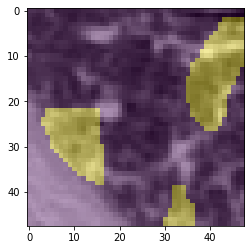

In [196]:
img = t_patch_img_with_annotation.numpy()
lbl = t_lbl_patches_with_annotation.numpy()
# i = 15000
plt.imshow(img[patch_idx[i],plane_idx[i],...], cmap='gray')
plt.imshow(lbl[patch_idx[i],plane_idx[i],...], alpha=0.4)
lbl[patch_idx[i],plane_idx[i],...].max()


In [216]:
#reshape labels
t_patch_lbl_with_annotation = tf.cast(t_patch_lbl_with_annotation, dtype = tf.int32)
t_patch_lbl_with_annotation = tf.one_hot(t_patch_lbl_with_annotation, 6)
t_patch_lbl_with_annotation.shape

TensorShape([2113, 6])

### Create dataset

In [217]:
#dataset loader
dataset = tf.data.Dataset.from_tensor_slices((t_patch_img_with_annotation, t_patch_lbl_with_annotation))
dataset.element_spec


(TensorSpec(shape=(30, 48, 48), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [218]:
#save dataset
path = '../../../data/'
dataset = tf.data.experimental.save(dataset, path)